In this notebook, we plot transects collected during CLIVAR cruises in 2012 and 2021. The aim is to compare the structure of NASTMW in the simulations with observations.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy as cart
import cmocean
import pandas as pd
import tqdm
from scipy import stats
from matplotlib.colors import TwoSlopeNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
import gsw

We only select data between 15N and 40N

In [3]:
ds_A20_1997_CTD = xr.open_dataset("data/A20_1997/10_316N151_3_ctd.nc").where(lambda x: (x.latitude > 15) * (x.latitude < 40), drop=True)
ds_A20_1997_CTD_full = xr.open_dataset("data/A20_1997/10_316N151_3_ctd.nc")
ds_A20_2003_CTD = xr.open_dataset("data/A20_2003/9_316N200309_ctd.nc").where(lambda x: (x.latitude > 15) * (x.latitude < 40), drop=True)
ds_A20_2012_CTD = xr.open_dataset("data/A20_2012/9_33AT20120419_ctd.nc").where(lambda x: (x.latitude > 15) * (x.latitude < 40), drop=True)

# CTD

In [4]:
ds_A20_2003_CTD = ds_A20_2003_CTD.assign_coords({"z" : gsw.z_from_p(ds_A20_2003_CTD.pressure, ds_A20_2003_CTD.latitude)})
ds_A20_2012_CTD = ds_A20_2012_CTD.assign_coords({"z" : gsw.z_from_p(ds_A20_2012_CTD.pressure, ds_A20_2012_CTD.latitude)})

In [5]:
for ds in [ds_A20_2003_CTD, ds_A20_2012_CTD]:
    dtdz = np.zeros(ds.ctd_temperature.shape)
    for profile in ds.N_PROF.data:
        dtdz[profile, :] = ds.isel(N_PROF=profile).ctd_temperature.differentiate(coord="z").data
    ds['dtdz'] = xr.DataArray(dtdz, dims=ds.dims)

In [6]:
gebco_coarsened = xr.open_dataset("~/misc/GEBCO_2022_coarsened12.nc")

In [7]:
gebco_coarsened_na = gebco_coarsened.isel(lon=slice(950,2160), lat=slice(1080,2160))

In [8]:
def plot_track(ds):
    fig = plt.Figure()
    ax = plt.axes(projection=cart.crs.Robinson())
    ax.gridlines(draw_labels=['left', 'bottom'])
    ax.coastlines()
    ax.set_extent([-84, -30, 10, 55], crs=cart.crs.PlateCarree())
    ax.scatter(ds.longitude.data, ds.latitude.data, transform=cart.crs.PlateCarree(), color='red', s=3)
    gebco_coarsened_na.elevation.plot(ax=ax, transform=cart.crs.PlateCarree(), zorder=-1)
    try:
        title = [line for line in ds.comments.split("\n") if "cruise" in line or "Cruise" in line][0] + "\n" +\
        [line for line in ds.comments.split("\n") if "date" in line or "Date" in line or "DATE" in line][0]
        ax.set_title(title)
    except:
        pass
    plt.show()

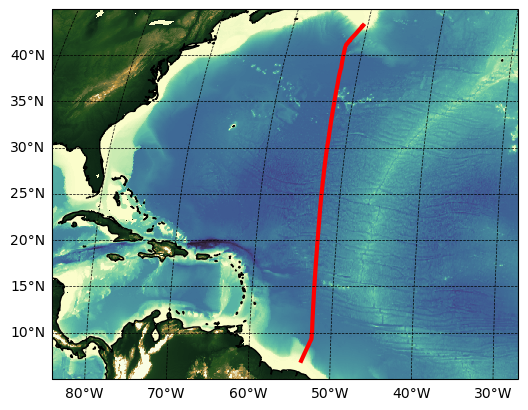

In [9]:
fig = plt.Figure(figsize=(3,3))
ax = plt.axes(projection=cart.crs.Robinson())
ax.gridlines(draw_labels=['left', 'bottom'], color='black', linestyle='--', linewidth=0.5)
ax.coastlines()
ax.set_extent([-84, -30, 5, 45], crs=cart.crs.PlateCarree())
norm = TwoSlopeNorm(vmin=gebco_coarsened_na.elevation.min(), vmax=1500, vcenter=0)
gebco_coarsened_na.elevation.plot(ax=ax, transform=cart.crs.PlateCarree(), zorder=-1, cmap=cmocean.cm.topo, norm=norm, add_colorbar=False)
ax.plot(ds_A20_1997_CTD_full.longitude.data, ds_A20_1997_CTD_full.latitude.data, transform=cart.crs.PlateCarree(), color='red', linewidth=3)

plt.savefig('WOCE_A20.png', dpi=300, transparent=True, bbox_inches='tight')

In [10]:
def plot_section(ds, variables=["ctd_temperature", "ctd_salinity", "dtdz"]): 
    fig, axes = plt.subplots(ncols=3, figsize=(20, 4))
    for ax in axes:
        ax.set_ylim(-600, 0)

    temperature_mask = (ds.ctd_temperature > 17) * (ds.ctd_temperature < 19)
    filtered_dtdz_mask = (ds.dtdz < 0.01).rolling(dim={'N_LEVELS': 20 }, min_periods=3, center=True).mean().T > 0.5
    EDW_mask = temperature_mask * filtered_dtdz_mask

    z_flat = ds.z.data.flatten()
    lat_flat = (ds.z * 0 + ds.latitude).data.flatten()

    clevels = {"ctd_temperature" : range(16, 21), 
    "ctd_salinity" : np.arange(36.3,36.7, 0.1),
    "dtdz" : [0.01]}

    cflevels = {"ctd_temperature" : 20, 
    "ctd_salinity" : 20,
    "dtdz" : np.arange(-0.01, 0.1, 0.005)}

    titles = {
        "ctd_temperature" : "Temperature [°C]",
        "ctd_salinity" : "Salinity [psu]", 
        "dtdz" : "dt/dz [°C / m]"
    }

    for idx, var in enumerate(variables):
        data_flat = ds[var].data.flatten()
        nanmask = np.isnan(data_flat)
        
        contourf = axes[idx].tricontourf(lat_flat[~nanmask], z_flat[~nanmask], data_flat[~nanmask], levels=cflevels[var])
        if var != 'dtdz':
            contourbk = axes[idx].tricontour(lat_flat[~nanmask], z_flat[~nanmask], data_flat[~nanmask], levels=clevels[var], colors='k', linewidths=1)
        axes[idx].set_title(titles[var])
        fig.colorbar(contourf)

    for ax in axes:
        contourw = ax.tricontour(lat_flat[~nanmask], z_flat[~nanmask], EDW_mask.data.flatten()[~nanmask], levels=[0.5], colors='w', linewidths=1)
        ax.set_xlabel("Latitude [°]")
        ax.set_ylabel("Depth")
    
    try:
        fig.suptitle(f"{[line for line in ds.comments.split(chr(10)) if 'cruise' in line or 'Cruise' in line][0]} ({[line for line in ds.comments.split(chr(10)) if 'date' in line or 'Date' in line or 'DATE' in line][0]})")
    except:
        pass
# plt.tight_layout()
plt.show()
    
    

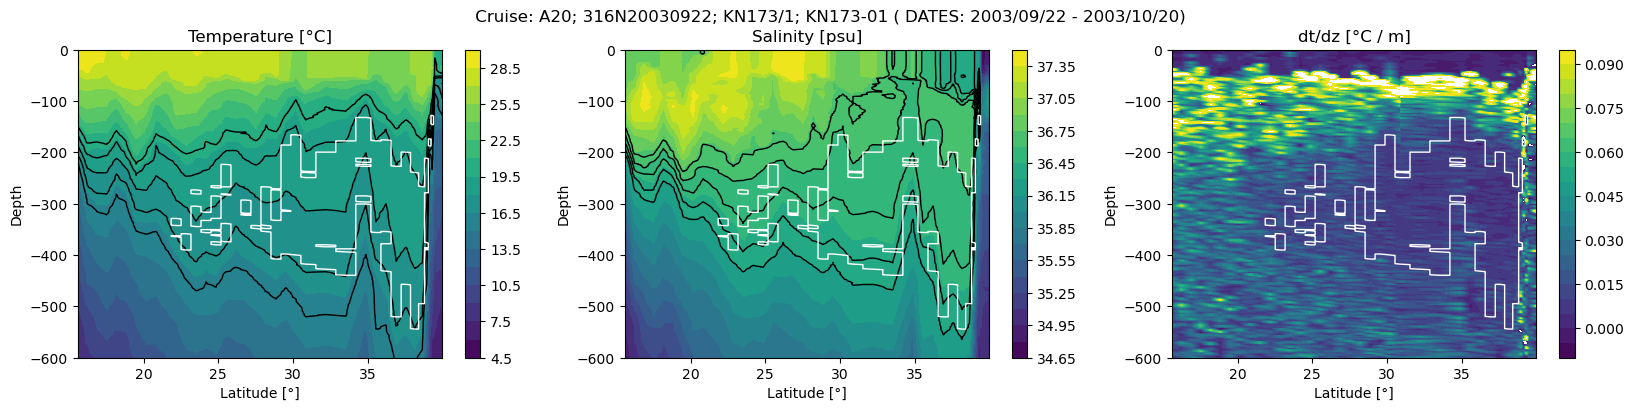

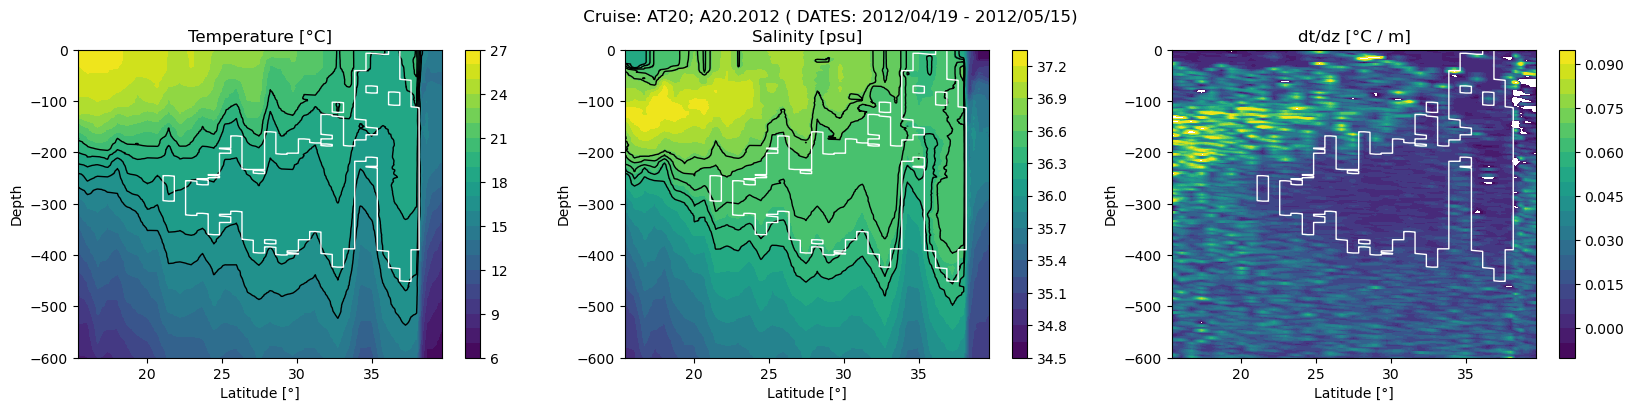

In [11]:
for ds in [ds_A20_2003_CTD, ds_A20_2012_CTD]:
    plot_section(ds.where(lambda x: x.pressure < 650, drop=True))
